# Design Single Country Nat Cat Bonds

In [44]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import pay_opt as po
import alt_pay_opt as apo
client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perform natural hazard simulation 
### Define variables for cat bonds

In [2]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

#choose country
country = 174

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
upper_rp = 200
lower_rp = 100

### Load TC Tracks for basin

currently not needed because I incorporated it into the ex.init_TC_exp function -> still coudnt figure out how to load exisitng tc track files -> it takes forever without throwing an error

In [3]:
#storms_basin = hst.init_STORM_tracks(basins=basins, load_fls=False)

### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


STORM basin of country:  SI
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------


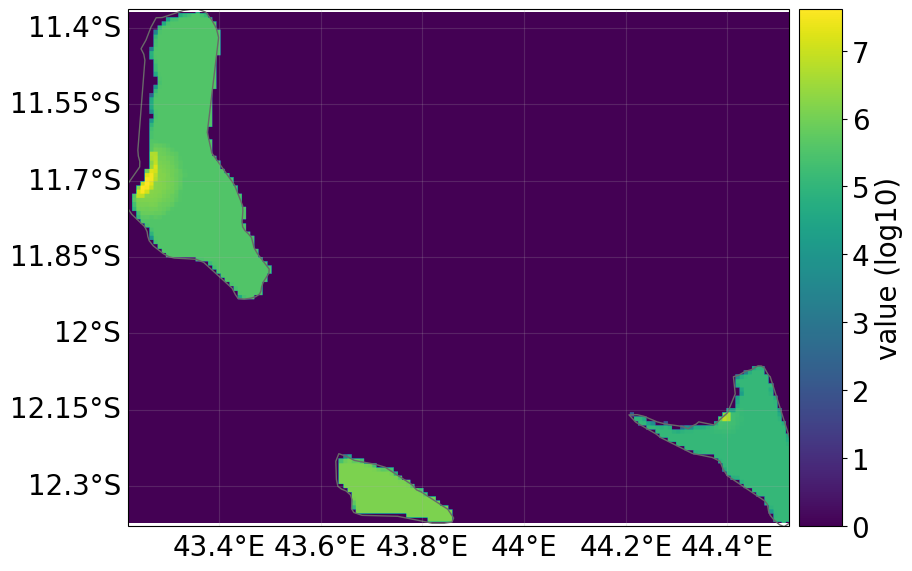

In [4]:
exp, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(country, load_fls=True)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


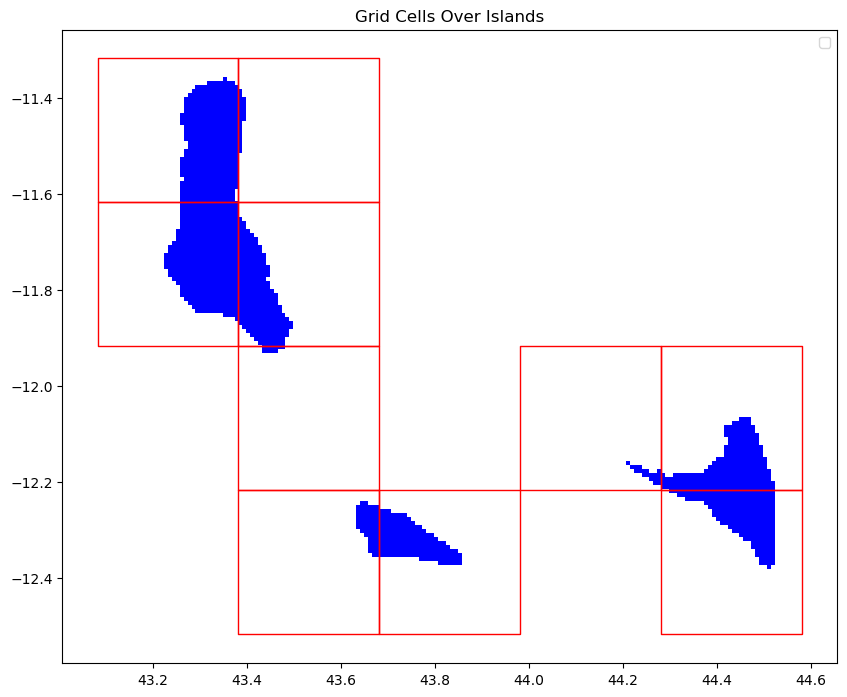

In [5]:
rst_grid = grd.init_grid(exp)

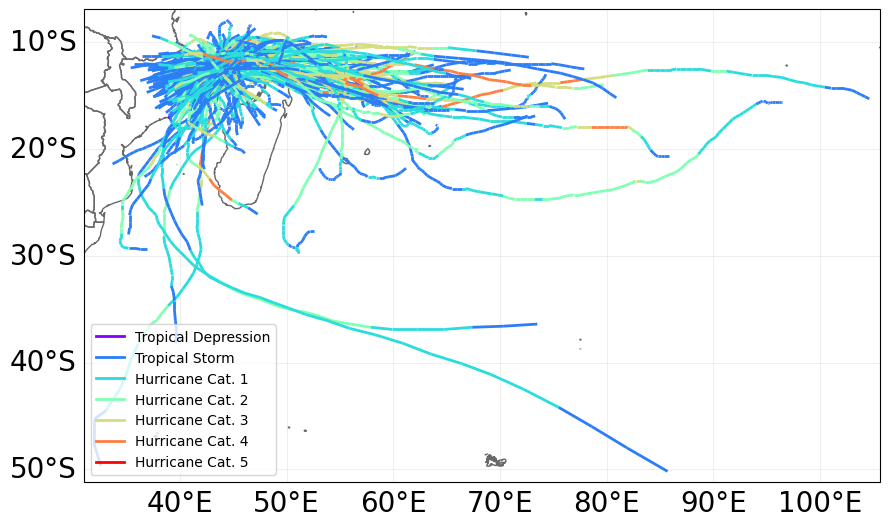

In [6]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot()
ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

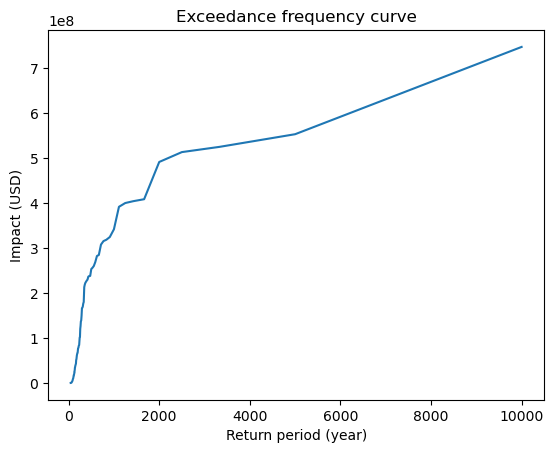

In [7]:
imp, imp_per_exp, agg_exp, imp_grid_evt = cimp.init_imp(exp, tc_storms, rst_grid) 

## Optimize insurance policies

### Asses hazard intensity per event and grid cell
Creation of data frame which indicates the sustained wind speed per event and grid cell caclualted using max, mean or median statistic across hazard centroid located in each grid cell.

In [8]:
ws_grid = hig.init_ws_grid(tc_storms, agg_exp, 'mean')

#### Set the nominal
Can be set in diferent ways:
1. Protecting a specified percentage of e.g. GDP
2. Protecting damages of specified return period

In [9]:
#define nominal
nominal, tot_exp, nom_rel_exp = snom.init_nominal(impact=imp, exposure=exp, prot_rp=200)


The principal of the cat bond is: 68281241.57656431
Principal as perecntage of GDP: 0.05573800558011975


### Set boundarys for protected damage
1. Calculate damage return periods for grid cells
2. Set minimum damage which should be protected per grid cell
3. Adjust damage per grid and event dictionary. Damage below minimum damage should be zero. Optionally we can also set the maximum damage to the nominal, but the default is not to.

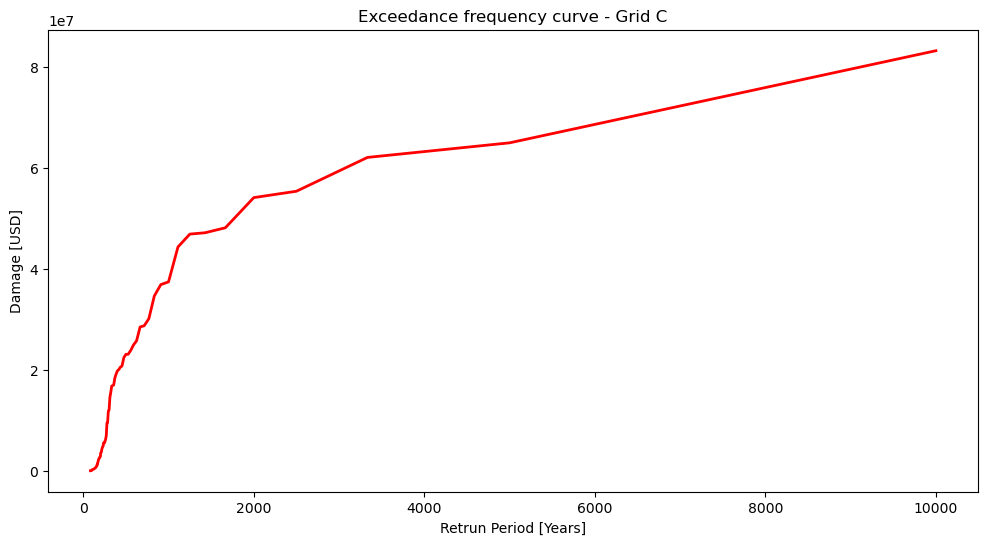

In [10]:
rp_dam_grid, dam_rp_per_grid, imp_grid_evt_flt = bpd.init_dam_ret_per_grid(imp_grid_evt, lower_rp, adj_max=False, plt_dam_rp_grid='C')

### Perform optimization
Optmizie payout function using linear payout inbetween a minimung triggering and a maximum wind speed. Wind speeds equal or higher than maximum wind speed result in the payout of the full principle. <br>
Wind speeds are optimized for each grid cell.

In [11]:
result, optimized_xs, optimized_ys = apo.init_alt_optimization(ws_grid, imp_grid_evt_flt, nominal)

{0: (20.0, 51.0), 1: (20.000473938294625, 126.64896175406103), 2: (20.0, 96.61663680672703), 3: (35.859549522750484, 148.70094199389408), 4: (20.30257811070869, 142.88321276969754), 5: (21.9498162065114, 69.07882331306645), 6: (38.38126085276729, 148.82225291394377), 7: (40.0, 150.0), 8: (22.854054088996335, 148.61968450641348), 9: (26.916041349283027, 146.97828524373628)}


### Assess payout vs damage for each event
1. Create a payout vs damage matrix per event
2. Plot payout vs damage on 1:1 scale

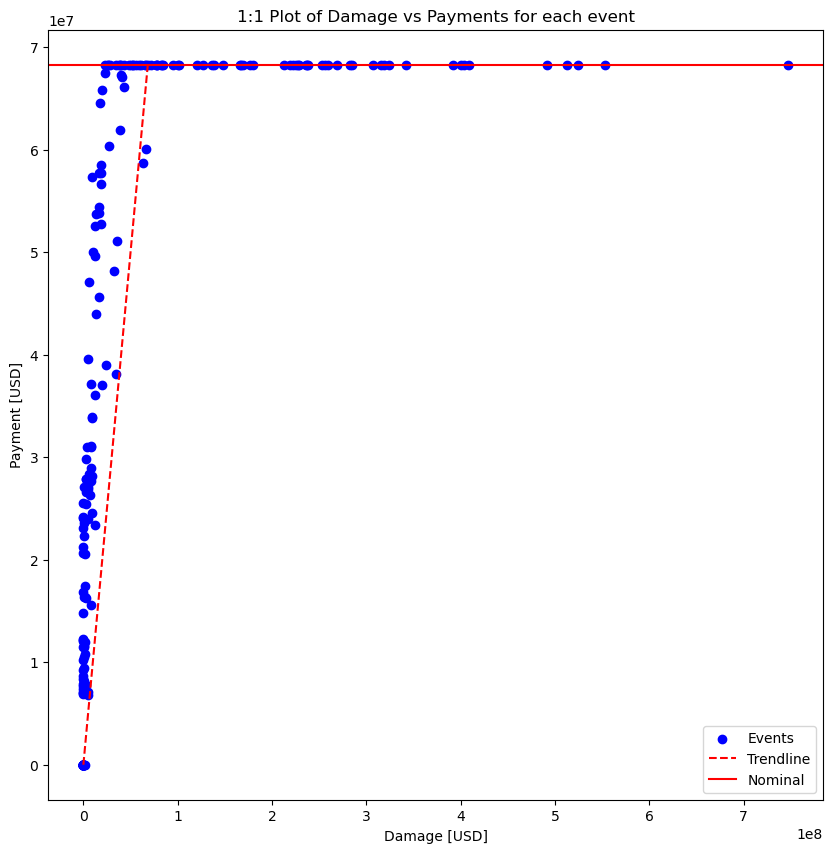

In [12]:
pay_dam_df = apo.alt_pay_vs_damage(imp_grid_evt_flt, optimized_xs, optimized_ys, ws_grid, nominal, include_plot=True)

### Calculate expected loss and attachment probability
1. Set annual probaility for hazard event
2. Simulate cat bond and calculate the expected loss as well as the annual attachment probability.

In [13]:
event_probability = len(pay_dam_df) / r
exp_loss_ann, att_prob = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal, event_probability)

Expected Loss = 0.011084045633108778
Attachment Probability = 0.0161


### Calculate premiums using:
1. IBRD multiplier model
2. Most recent artemis multiplier
3. Linear regression model of Chatoro et al. 2022

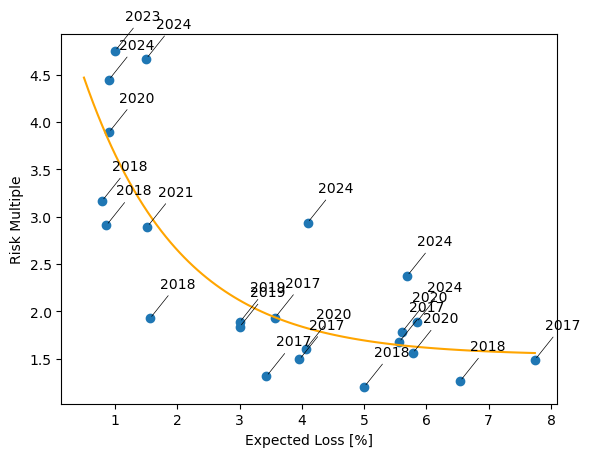

The premium based on past IBRD bonds is 3.894%
The premium based on the artemis multiplier is 4.556%
The premium based on the regression model from Chatoro et al. 2022 is 5.839%


In [14]:
params_ibrd = prib.init_prem_ibrd()
a, k, b = params_ibrd
artemis_multiplier = 4.11

premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
premium_artemis = exp_loss_ann * artemis_multiplier
premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100

print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%')
print(f'The premium based on the artemis multiplier is {round(premium_artemis*100, 3)}%')
print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%')

### Calculate cat bond metrics
1. Perform Monte-Carlo Simulation
2. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

### Simulate a 3-year cat bond

In [15]:
rf_rates = 0.05 #set risk free rate, either single value or array
premiums = np.arange(0.00, 0.21, 0.01) #set range of premiums

premium_simulation, returns = sb.init_bond_simulation(pay_dam_df, premiums, rf_rates, event_probability, nominal) #simulate cat bond using a Monte Carlo simulation

Intersection point using risk free interest rate of 5.0%: Premium = 0.0832, Sharpe Ratio = 1.0000
Required Sharpe Ratio: 1.0; Risk free rate: 5.0%; Required Premium: 8.319%; Risk Multiple: 7.506


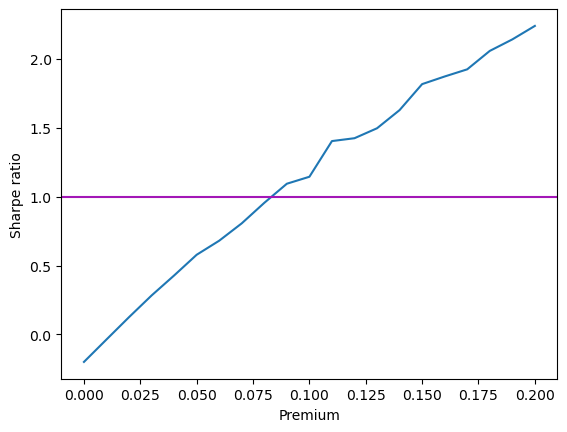

In [16]:
requ_sharpe_ratio = 1.0
requ_premiums = sb.init_requ_premium(requ_sharpe_ratio, premium_simulation, rf_rates) #calculate required premium to match minimum sharpe ratio
sb.display_premiums([requ_premiums], [requ_sharpe_ratio], rf_rates, premium_simulation, exp_loss_ann)   #plot premium versus sharpe ratio

In [17]:
high_yield_bond = pd.read_excel('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/3_m_treasury.xlsx')
mean_hy = high_yield_bond['Return'].mean()
risk_free_hy = high_yield_bond['Risk free'].mean()
std_hy = high_yield_bond['Return'].std()
VaR_01_hy = high_yield_bond['Return'].quantile(0.01)
VaR_05_hy = high_yield_bond['Return'].quantile(0.05)
ES_01_hy = high_yield_bond['Return'][high_yield_bond['Return'] < VaR_01_hy].mean() *-1
ES_05_hy = high_yield_bond['Return'][high_yield_bond['Return'] < VaR_05_hy].mean() *-1
sharpe_hy = (mean_hy - risk_free_hy) / std_hy
cond_sharpe_hy_01 = (mean_hy - risk_free_hy) / ES_01_hy
cond_sharpe_hy_05 = (mean_hy - risk_free_hy) / ES_05_hy

print('High yield bond sharpe ratio: ', sharpe_hy)
print('High yield bond conditional sharpe ratio (0.01): ', cond_sharpe_hy_01)
print('High yield bond conditional sharpe ratio (0.05): ', cond_sharpe_hy_05)

p = requ_premiums
premium_simulation_p, returns_p = sb.init_bond_simulation(pay_dam_df, p, rf_rates, event_probability, nominal) #simulate cat bond using a Monte Carlo simulation
print('Nat cat bond sharpe ratio: ', premium_simulation_p['Sharpe_ratio_ann'][0])
print('Nat cat bond conditional sharpe ratio (0.01): ', premium_simulation_p['Cond_sharpe_ratio_01'][0])
print('Nat cat bond conditional sharpe ratio (0.05): ', premium_simulation_p['Cond_sharpe_ratio_05'][0])

High yield bond sharpe ratio:  0.4230329028471114
High yield bond conditional sharpe ratio (0.01):  0.22385925404644622
High yield bond conditional sharpe ratio (0.05):  0.3749695788185157
Nat cat bond sharpe ratio:  0.9991981888899408
Nat cat bond conditional sharpe ratio (0.01):  0.20898211493080746
Nat cat bond conditional sharpe ratio (0.05):  0.46128434484725367


In [18]:
#save session varibales in database file
import dill
dill.dump_session('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/sessions/first_try.db')

In [19]:
#num_simulations = 20000
#
#requ_premium_sim, requ_premium_annual_returns, requ_premium_tot_returns = sb.init_bond_simulation(requ_premium)
#
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
#
#ax1.hist(requ_premium_annual_returns)
#ax1.text(-0.35, num_simulations-1000, f'Std: {round(np.std(requ_premium_annual_returns)*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-2000, f'VaR_1%: {round(requ_premium_sim["VaR_01_ann"][0]*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-3000, f'ES_1%: {round(requ_premium_sim["ES_01_ann"][0]*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-4000, f'Risk margin: {round(requ_premium_sim["Premium"][0]*100,2)}%', fontsize = 8)
#ax1.text(-0.35, num_simulations-5000, f'Sharpe ratio: {round(requ_premium_sim["Sharpe_ratio_ann"][0],2)}', fontsize = 8)
#ax1.text(-0.35, num_simulations-6000, f'Exp return: {round(np.mean(requ_premium_annual_returns)*100,2)}%', fontsize = 8)
#ax1.set_xlabel('Relative Returns')
#ax1.set_ylabel('Frequency')
#ax1.set_title('Histogram of annual returns for a 3-year cat bond')
#
#ax2.hist(requ_premium_tot_returns)
#ax2.text(-1.0, num_simulations-1000, f'Std: {round(np.std(requ_premium_tot_returns)*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-2000, f'VaR_1%: {round(requ_premium_sim["VaR_01_tot"][0]*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-3000, f'ES_1%: {round(requ_premium_sim["ES_01_tot"][0]*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-4000, f'Risk margin: {round(requ_premium_sim["Premium"][0]*100,2)}%', fontsize = 8)
#ax2.text(-1.0, num_simulations-5000, f'Sharpe ratio: {round(requ_premium_sim["Sharpe_ratio_tot"][0],2)}', fontsize = 8)
#ax2.text(-1.0, num_simulations-6000, f'Exp return: {round(np.mean(requ_premium_tot_returns)*100,2)}%', fontsize = 8)
#ax2.set_xlabel('Relative Returns')
##ax2.set_ylabel('Frequency')
#ax2.set_title('Histogram of total returns for a 3-year cat bond')
#
#plt.show()
#

## Perform cat bond simulation using different nominals

In [45]:
#define nominals
prot_share_arr = np.arange(0.01, 0.11, 0.01) #protected share of total exposure
arr_nominal = []

for prot_share in prot_share_arr:
    nominal, tot_exp, nom_rel_exp = snom.init_nominal(impact=None, exposure=exp, prot_share=prot_share, print_nom=False)
    arr_nominal.append(nominal)

print('Nominals calculated')

#optimize payout per grid for each nominal
optimized_xs_nom = {}
optimized_ys_nom = {}
result_nom = {}
pay_dam_df_nom = {}
exp_loss_ann_nom = {}
att_prob_nom = {}
premium_ibrd = {}
premium_artemis = {}
premium_regression = {}
premium_simulation = {}
returns = {}
premium_simulation_ibrd = {}
returns_ibrd = {}
premium_simulation_artemis = {}
returns_artemis = {}
premium_simulation_regression = {}
returns_regression = {}
requ_premiums_mod = {}
requ_premiums_high = {}
premiums = np.arange(0.00, 0.28, 0.01) #set range of premiums, to calculate required premium to beat sharpe ratio

for nom in arr_nominal:
    nom_str = str(nom)
    result_nom[nom_str], optimized_xs_nom[nom_str], optimized_ys_nom[nom_str] = apo.init_alt_optimization(ws_grid, imp_grid_evt_flt, nom, print_params=False)

    pay_dam_df_nom[nom_str] = apo.alt_pay_vs_damage(imp_grid_evt_flt, optimized_xs_nom[nom_str], optimized_ys_nom[nom_str], ws_grid, nom, include_plot=False)
    
    exp_loss_ann_nom[nom_str], att_prob_nom[nom_str] = sb.init_exp_loss_att_prob_simulation(pay_dam_df_nom[nom_str], nom, event_probability, print_prob=False)

    premium_ibrd[nom_str] = prib.monoExp(exp_loss_ann_nom[nom_str]*100, a, k, b) * exp_loss_ann_nom[nom_str]
    premium_artemis[nom_str] = exp_loss_ann_nom[nom_str] * artemis_multiplier
    premium_regression[nom_str] = cp.calc_premium_regression(exp_loss_ann_nom[nom_str] *100)/100
    
    premium_simulation_ibrd[nom_str], returns_ibrd[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_ibrd[nom_str], rf_rates, event_probability, nom) 
    premium_simulation_artemis[nom_str], returns_artemis[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_artemis[nom_str], rf_rates, event_probability, nom) 
    premium_simulation_regression[nom_str], returns_regression[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_regression[nom_str], rf_rates, event_probability, nom) 
    premium_simulation[nom_str], returns[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premiums, rf_rates, event_probability, nom) 
    
    requ_premiums_mod[nom_str] = sb.init_requ_premium(0.5, premium_simulation[nom_str], rf_rates, print_prem=False)
    requ_premiums_high[nom_str] = sb.init_requ_premium(1.0, premium_simulation[nom_str], rf_rates, print_prem=False) 
    #sb.display_premiums([requ_premiums_mod[nom_str], requ_premiums_high[nom_str]], [1.0, 2.0], rf_rates, premium_simulation[nom_str], exp_loss_ann_nom[nom_str])   

Nominals calculated


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:203: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:203: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


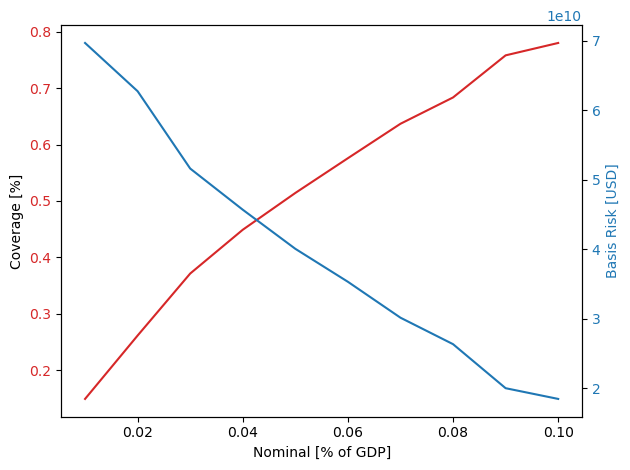

In [46]:
coverage_nom = np.array((premium_simulation['12250391.966109099']['Coverage'].mean(), premium_simulation['24500783.932218198']['Coverage'].mean(), premium_simulation['36751175.8983273']['Coverage'].mean(), 
                        premium_simulation['49001567.864436395']['Coverage'].mean(), premium_simulation['61251959.8305455']['Coverage'].mean(), premium_simulation['73502351.7966546']['Coverage'].mean(), 
                        premium_simulation['85752743.7627637']['Coverage'].mean(), premium_simulation['98003135.72887279']['Coverage'].mean(), premium_simulation['110253527.69498189']['Coverage'].mean(), 
                        premium_simulation['122503919.66109098']['Coverage'].mean()))

basis_risk_nom = np.array((premium_simulation['12250391.966109099']['Basis_risk'].mean(), premium_simulation['24500783.932218198']['Basis_risk'].mean(), premium_simulation['36751175.8983273']['Basis_risk'].mean(), 
                        premium_simulation['49001567.864436395']['Basis_risk'].mean(), premium_simulation['61251959.8305455']['Basis_risk'].mean(), premium_simulation['73502351.7966546']['Basis_risk'].mean(), 
                        premium_simulation['85752743.7627637']['Basis_risk'].mean(), premium_simulation['98003135.72887279']['Basis_risk'].mean(), premium_simulation['110253527.69498189']['Basis_risk'].mean(), 
                        premium_simulation['122503919.66109098']['Basis_risk'].mean())) *-1

tot_pay_nom = np.array((premium_simulation['12250391.966109099']['Average Payments'].mean(), premium_simulation['24500783.932218198']['Average Payments'].mean(), premium_simulation['36751175.8983273']['Average Payments'].mean(), 
                        premium_simulation['49001567.864436395']['Average Payments'].mean(), premium_simulation['61251959.8305455']['Average Payments'].mean(), premium_simulation['73502351.7966546']['Average Payments'].mean(), 
                        premium_simulation['85752743.7627637']['Average Payments'].mean(), premium_simulation['98003135.72887279']['Average Payments'].mean(), premium_simulation['110253527.69498189']['Average Payments'].mean(), 
                        premium_simulation['122503919.66109098']['Average Payments'].mean()))/tot_exp 

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, coverage_nom, color=color)
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Coverage [%]')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Basis Risk [USD]', color=color)  # we already handled the x-label with ax1
ax2.plot(prot_share_arr, basis_risk_nom, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



plot premium vs coverage. How much do I need to pay for a certain coverage. Also include what a certain coverage would mean money wise for the country -> how much is paid relative to gdp

Think about other coverage metrics -> compare them.

What is good benchmark metric?

Cost-benefit with premium plot.

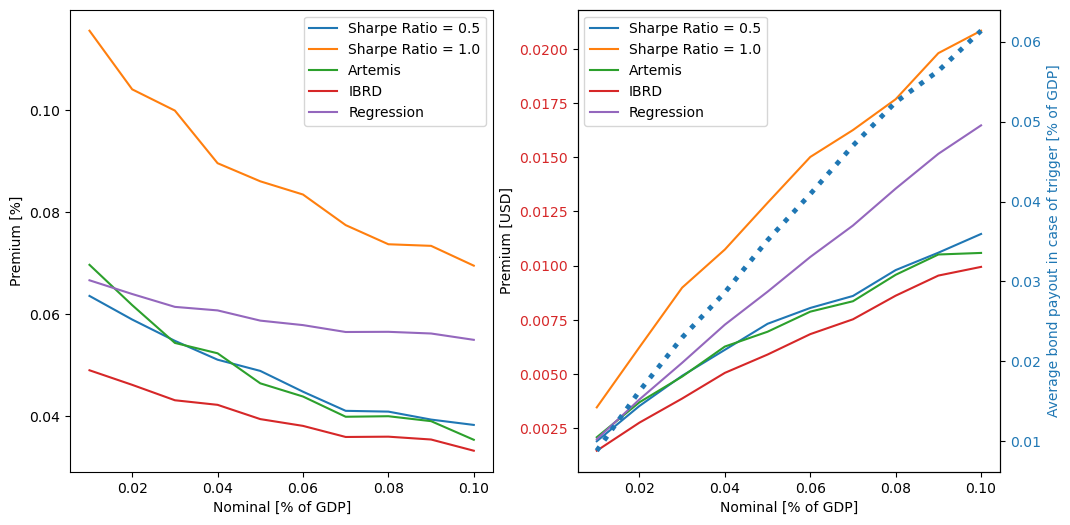

In [47]:

requ_premiums_mod_arr = np.array(fct.get_all_values(requ_premiums_mod))
requ_premiums_high_arr = np.array(fct.get_all_values(requ_premiums_high))
premium_artemis_arr = np.array(fct.get_all_values(premium_artemis))
premium_ibrd_arr = np.array(fct.get_all_values(premium_ibrd))
premium_regression_arr = np.array(fct.get_all_values(premium_regression))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(prot_share_arr, requ_premiums_mod_arr, label='Sharpe Ratio = 0.5')
ax1.plot(prot_share_arr, requ_premiums_high_arr, label='Sharpe Ratio = 1.0')
ax1.plot(prot_share_arr, premium_artemis.values(), label='Artemis')
ax1.plot(prot_share_arr, premium_ibrd.values(), label='IBRD')
ax1.plot(prot_share_arr, premium_regression.values(), label='Regression')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Premium [%]')
ax1.legend()

color = 'tab:red'
ax2.plot(prot_share_arr, (requ_premiums_mod_arr * arr_nominal)*3 / tot_exp, label='Sharpe Ratio = 0.5')
ax2.plot(prot_share_arr, (requ_premiums_high_arr * arr_nominal)*3 / tot_exp, label='Sharpe Ratio = 1.0')
ax2.plot(prot_share_arr, (premium_artemis_arr * arr_nominal)*3 / tot_exp, label='Artemis')
ax2.plot(prot_share_arr, (premium_ibrd_arr * arr_nominal)*3 / tot_exp, label='IBRD')
ax2.plot(prot_share_arr, (premium_regression_arr * arr_nominal)*3 / tot_exp, label='Regression')
ax2.set_xlabel('Nominal [% of GDP]')
ax2.set_ylabel('Premium [USD]')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax2.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel('Average bond payout in case of trigger [% of GDP]', color=color)  # we already handled the x-label with ax1
ax3.plot(prot_share_arr, tot_pay_nom, color=color, linewidth=3.5, linestyle='dotted', label='Avg. Payout')
ax3.tick_params(axis='y', labelcolor=color)

ax2.legend()

plt.show()

In [43]:
print(tot_exp*0.001)

1225039.19661091


What sharpe ratio do the calculated premiums imply.

Why do the curves behave like they do? -> make comments

Check on stop payment if payout happpens.

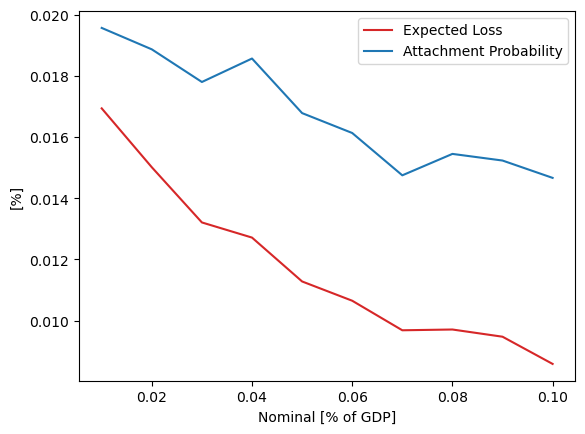

In [48]:
exp_loss_arr = np.array(fct.get_all_values(exp_loss_ann_nom))
att_prob_arr = np.array(fct.get_all_values(att_prob_nom))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, exp_loss_arr, color=color, label='Expected Loss')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('[%]')

color = 'tab:blue'
ax1.plot(prot_share_arr, att_prob_arr, color=color, label='Attachment Probability')

plt.legend()
plt.show()

In [49]:
premium_simulation_cond = {}
returns_cond = {}
for nom in arr_nominal:
    nom_str = str(nom)
    premium_simulation_cond[nom_str], returns_cond[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], requ_premiums_mod[nom_str], rf_rates, event_probability, nom) #simulate cat bond using a Monte Carlo simulation

cond_shp_rat_01 = np.array((premium_simulation_cond['12250391.966109099']['Cond_sharpe_ratio_01'][0], premium_simulation_cond['24500783.932218198']['Cond_sharpe_ratio_01'][0], premium_simulation_cond['36751175.8983273']['Cond_sharpe_ratio_01'][0], 
                        premium_simulation_cond['49001567.864436395']['Cond_sharpe_ratio_01'][0], premium_simulation_cond['61251959.8305455']['Cond_sharpe_ratio_01'][0], premium_simulation_cond['73502351.7966546']['Cond_sharpe_ratio_01'][0], 
                        premium_simulation_cond['85752743.7627637']['Cond_sharpe_ratio_01'][0], premium_simulation_cond['98003135.72887279']['Cond_sharpe_ratio_01'][0], premium_simulation_cond['110253527.69498189']['Cond_sharpe_ratio_01'][0], 
                        premium_simulation_cond['122503919.66109098']['Cond_sharpe_ratio_01'][0]))

cond_shp_rat_05 = np.array((premium_simulation_cond['12250391.966109099']['Cond_sharpe_ratio_05'][0], premium_simulation_cond['24500783.932218198']['Cond_sharpe_ratio_05'][0], premium_simulation_cond['36751175.8983273']['Cond_sharpe_ratio_05'][0], 
                        premium_simulation_cond['49001567.864436395']['Cond_sharpe_ratio_05'][0], premium_simulation_cond['61251959.8305455']['Cond_sharpe_ratio_05'][0], premium_simulation_cond['73502351.7966546']['Cond_sharpe_ratio_05'][0], 
                        premium_simulation_cond['85752743.7627637']['Cond_sharpe_ratio_05'][0], premium_simulation_cond['98003135.72887279']['Cond_sharpe_ratio_05'][0], premium_simulation_cond['110253527.69498189']['Cond_sharpe_ratio_05'][0], 
                        premium_simulation_cond['122503919.66109098']['Cond_sharpe_ratio_05'][0]))


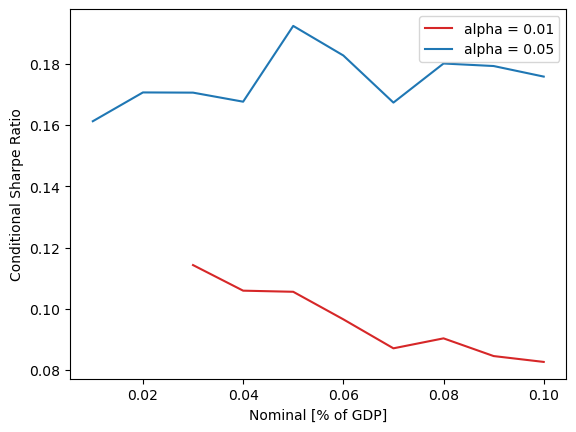

In [50]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, cond_shp_rat_01, color=color, label='alpha = 0.01')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Conditional Sharpe Ratio')

color = 'tab:blue'
ax1.plot(prot_share_arr, cond_shp_rat_05, color=color, label='alpha = 0.05')

plt.legend()
plt.show()

splitting premiums according to share of single country regarding total of expected shortfall (if this is the driver of pricing)

For a given nominal what premium do I have to pay?

For a given premium how much can I increase the coverage?

Look at cost benefits

In [26]:
d = returns['122503919.66109098']
d
s = premium_simulation['122503919.66109098']
s

,Premium,Sharpe_ratio_ann,Cond_sharpe_ratio_01,Cond_sharpe_ratio_05,VaR_01_ann,ES_01_ann,Sharpe_ratio_tot,VaR_01_tot,ES_01_tot,Coverage,Basis_risk,Average Payments
0,0.0,-0.18561,-0.029476,-0.056695,-0.306007,-0.323407,-0.18561,-0.918022,-0.970221,0.782715,-17939273546.750275,73938153.628058
1,0.01,0.002233,0.000365,0.000737,-0.293333,-0.322219,0.002233,-0.88,-0.966656,0.894932,-7754170650.727516,73385784.930931
2,0.02,0.17326,0.029542,0.060837,-0.304624,-0.322567,0.17326,-0.913871,-0.967701,0.811584,-15753433341.883247,73437494.254915
3,0.03,0.361988,0.062326,0.127897,-0.29379,-0.318359,0.361988,-0.881369,-0.955077,0.802793,-16251388754.252197,76570045.638382
4,0.04,0.517823,0.088309,0.198964,-0.303333,-0.331784,0.517823,-0.91,-0.995352,0.756278,-21743255710.58268,74800746.120472
5,0.05,0.690846,0.124737,0.273349,-0.283459,-0.315727,0.690846,-0.850376,-0.947182,0.771745,-19660147442.852623,76405017.545879
6,0.06,0.865545,0.158525,0.345181,-0.284549,-0.31309,0.865545,-0.853646,-0.939271,0.765177,-19691302057.872398,78536994.32884
7,0.07,0.978156,0.177976,0.450502,-0.293333,-0.330006,0.978156,-0.88,-0.990017,0.74591,-22862531724.24205,74572962.479915
8,0.08,1.085129,0.206206,0.527238,-0.29,-0.329637,1.085129,-0.87,-0.988911,0.793885,-18429510782.128189,76409270.827613
9,0.09,1.328129,0.256937,0.671623,-0.274928,-0.308221,1.328129,-0.824783,-0.924662,0.779354,-17762771829.462891,74869562.042246


In [27]:
np.std(returns['122503919.66109098']['Annual'][8])

0.06264050643598247

In [28]:
(0.11 -0.05)/0.06

1.0